In [36]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
lya = 1215.67

In [37]:
# main folder where the processed files are
nside = 16
basedir = '/Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside{}'.format(nside)
#basedir = '/Users/James/Projects/LyaCoLoRe/example_data/update_080518/'

In [38]:
pix = 1
pix_100 = int(pix/100)
dirname = basedir+'/'+str(pix_100)+'/'+str(pix)+'/'
suffix = str(nside)+'-'+str(pix)+'.fits'
print('dir name',dirname)

dir name /Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside16/0/1/


In [39]:
# open picca files with and without RSDs, and the 
gaussian_RSD_filename = dirname+'/picca-gaussian-RSD-'+suffix
gaussian_RSD = fits.open(gaussian_RSD_filename)
print('With RSDs:')
gaussian_RSD.info()

gaussian_noRSD_filename = dirname+'/picca-gaussian-noRSD-'+suffix
gaussian_noRSD = fits.open(gaussian_noRSD_filename)
print('\nWithout RSDs:')
gaussian_RSD.info()

With RSDs:
Filename: /Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside16/0/1//picca-gaussian-RSD-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CATALOG       1 PrimaryHDU      12   (5, 568)   float64   
  1  IV            1 ImageHDU        13   (5, 568)   float32   
  2  LOGLAM_MAP    1 ImageHDU        12   (568,)   float32   
  3  CATALOG       1 BinTableHDU     28   5R x 7C   [E, E, E, K, E, K, K]   

Without RSDs:
Filename: /Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside16/0/1//picca-gaussian-RSD-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CATALOG       1 PrimaryHDU      12   (5, 568)   float64   
  1  IV            1 ImageHDU        13   (5, 568)   float32   
  2  LOGLAM_MAP    1 ImageHDU        12   (568,)   float32   
  3  CATALOG       1 BinTableHDU     28   5R x 7C   [E, E, E, K, E, K, K]   


In [40]:
print('Check that the highest z QSO is the same in both files:')
iskewer = np.argmax(gaussian_RSD[3].data['Z'])
print(iskewer,gaussian_RSD[3].data['THING_ID'][iskewer])
iskewer = np.argmax(gaussian_noRSD[3].data['Z'])
print(iskewer,gaussian_noRSD[3].data['THING_ID'][iskewer])

Check that the highest z QSO is the same in both files:
4 267
4 267


In [41]:
# open colore file to get a velocity skewer
gaussian_colore_filename = dirname+'/gaussian-colore-'+suffix
gaussian_colore = fits.open(gaussian_colore_filename)
print('colore:')
gaussian_colore.info()
iskewer_colore = np.argmax(gaussian_colore[1].data['MOCKID']==gaussian_RSD[3].data['THING_ID'][iskewer])
print(iskewer_colore,gaussian_colore[1].data['MOCKID'][iskewer_colore])

colore:
Filename: /Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside16/0/1//gaussian-colore-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU     26   7R x 6C   [E, E, E, E, E, K]   
  2  GAUSSIAN_DELTA    1 ImageHDU        13   (2048, 7)   float32   
  3  VELOCITY      1 ImageHDU        13   (2048, 7)   float32   
  4  COSMO         1 BinTableHDU     22   2048R x 4C   [E, E, E, E]   
6 267


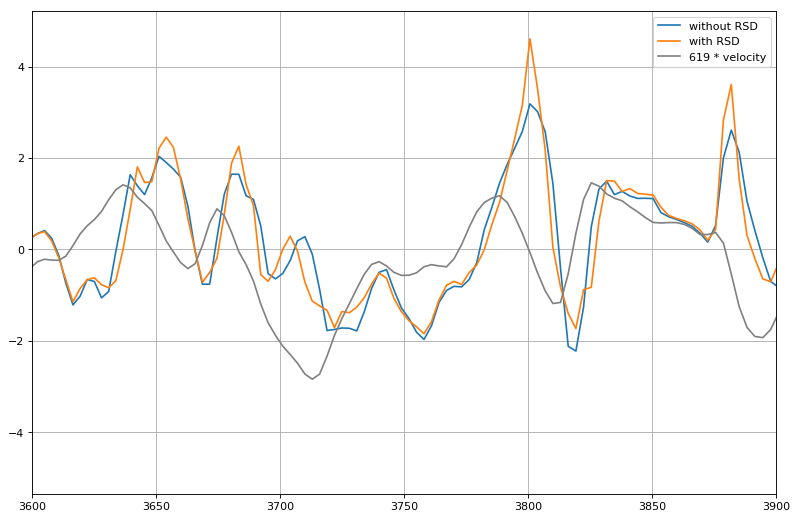

In [47]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(10**gaussian_noRSD[2].data,gaussian_noRSD[0].data[:,iskewer],label='without RSD')
plt.plot(10**gaussian_RSD[2].data,gaussian_RSD[0].data[:,iskewer],label='with RSD')

scale_vel = 3/max(gaussian_colore[3].data[iskewer_colore,:])
plt.plot(lya*(1+gaussian_colore[4].data['Z']),scale_vel*gaussian_colore[3].data[iskewer_colore,:],label='{:2.0f} * velocity'.format(scale_vel),c=(0.5,0.5,0.5))

x_lower = 3600.
x_width = 300.
x_upper = x_lower + x_width

plt.xlim(x_lower,x_upper)
plt.legend()
plt.grid()
plt.show()

In [48]:
gaussian_colore_filename = dirname+'/gaussian-colore-'+suffix
gaussian_colore = fits.open(gaussian_colore_filename)
gaussian_colore.info()

gaussian_skewer = gaussian_colore[2].data[iskewer_colore,:]
velocity_skewer = gaussian_colore[3].data[iskewer_colore,:]
Z = gaussian_colore[4].data['Z']
N_cells = gaussian_skewer.shape[0]

Filename: /Users/jfarr/Projects/test_data/process_output_G_hZsmooth_4096_32_sr2.0_bm1_biasG18_picos_nside16/0/1//gaussian-colore-16-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU     26   7R x 6C   [E, E, E, E, E, K]   
  2  GAUSSIAN_DELTA    1 ImageHDU        13   (2048, 7)   float32   
  3  VELOCITY      1 ImageHDU        13   (2048, 7)   float32   
  4  COSMO         1 BinTableHDU     22   2048R x 4C   [E, E, E, E]   


In [49]:
"""
The below mimics the process of adding linear RSDs as defined in process_functions.py
It shows the 'shifting' of the cells by listing the original index and z, the new ones and the weights.
It them plots a gaussian skewer with and without RSDs, and the corresponding (scaled) velocity skewer."""

"\nThe below mimics the process of adding linear RSDs as defined in process_functions.py\nIt shows the 'shifting' of the cells by listing the original index and z, the new ones and the weights.\nIt them plots a gaussian skewer with and without RSDs, and the corresponding (scaled) velocity skewer."

In [50]:
new_gaussian_skewer = np.zeros(gaussian_skewer.shape)
for j in range(N_cells):
    z_cell=Z[j]
    dz_cell = velocity_skewer[j]
    new_z_cell=z_cell+dz_cell
    j_upper = np.searchsorted(Z,new_z_cell)
    j_lower = j_upper - 1
    if j_lower < 0:
        w_upper = 1.0
        w_lower = 0.0
        j_lower += 1
    elif j_upper >= N_cells:
        w_lower = 1.0
        w_upper = 0.0
        j_upper -= 1
    else:
        z_upper = Z[j_upper]
        z_lower = Z[j_lower]
        w_upper = abs(new_z_cell - z_lower)/(z_upper - z_lower)
        w_lower = abs(new_z_cell - z_upper)/(z_upper - z_lower)
    print('z={:2.4f}, j={:2.0f} -> dz: {:2.4f} -> new_z: {:2.4f}, j in [{:2.0f},{:2.0f}], w_lower: {:2.4f}, w_upper: {:2.4f}'.format(z_cell,j,dz_cell,new_z_cell,j_lower,j_upper,w_lower,w_upper))
    new_gaussian_skewer[j_upper] += w_upper*gaussian_skewer[j]
    new_gaussian_skewer[j_lower] += w_lower*gaussian_skewer[j]

z=0.0004, j= 0 -> dz: 0.0015 -> new_z: 0.0019, j in [ 1, 2], w_lower: 0.0509, w_upper: 0.9491
z=0.0012, j= 1 -> dz: 0.0019 -> new_z: 0.0031, j in [ 3, 4], w_lower: 0.5706, w_upper: 0.4294
z=0.0020, j= 2 -> dz: 0.0022 -> new_z: 0.0042, j in [ 4, 5], w_lower: 0.2099, w_upper: 0.7901
z=0.0028, j= 3 -> dz: 0.0022 -> new_z: 0.0050, j in [ 5, 6], w_lower: 0.1965, w_upper: 0.8035
z=0.0036, j= 4 -> dz: 0.0020 -> new_z: 0.0056, j in [ 6, 7], w_lower: 0.4058, w_upper: 0.5942
z=0.0043, j= 5 -> dz: 0.0019 -> new_z: 0.0062, j in [ 7, 8], w_lower: 0.6142, w_upper: 0.3858
z=0.0051, j= 6 -> dz: 0.0017 -> new_z: 0.0069, j in [ 8, 9], w_lower: 0.7979, w_upper: 0.2021
z=0.0059, j= 7 -> dz: 0.0015 -> new_z: 0.0075, j in [ 8, 9], w_lower: 0.0659, w_upper: 0.9341
z=0.0067, j= 8 -> dz: 0.0013 -> new_z: 0.0080, j in [ 9,10], w_lower: 0.4107, w_upper: 0.5893
z=0.0075, j= 9 -> dz: 0.0009 -> new_z: 0.0084, j in [10,11], w_lower: 0.8652, w_upper: 0.1348
z=0.0083, j=10 -> dz: 0.0005 -> new_z: 0.0088, j in [10,11],

z=0.9288, j=918 -> dz: -0.0004 -> new_z: 0.9285, j in [917,918], w_lower: 0.2731, w_upper: 0.7269
z=0.9302, j=919 -> dz: -0.0004 -> new_z: 0.9297, j in [918,919], w_lower: 0.3235, w_upper: 0.6765
z=0.9315, j=920 -> dz: -0.0006 -> new_z: 0.9309, j in [919,920], w_lower: 0.4349, w_upper: 0.5651
z=0.9329, j=921 -> dz: -0.0006 -> new_z: 0.9323, j in [920,921], w_lower: 0.4172, w_upper: 0.5828
z=0.9342, j=922 -> dz: -0.0003 -> new_z: 0.9340, j in [921,922], w_lower: 0.1945, w_upper: 0.8055
z=0.9356, j=923 -> dz: 0.0002 -> new_z: 0.9358, j in [923,924], w_lower: 0.8389, w_upper: 0.1611
z=0.9370, j=924 -> dz: 0.0007 -> new_z: 0.9377, j in [924,925], w_lower: 0.4615, w_upper: 0.5385
z=0.9383, j=925 -> dz: 0.0011 -> new_z: 0.9395, j in [925,926], w_lower: 0.1570, w_upper: 0.8430
z=0.9397, j=926 -> dz: 0.0014 -> new_z: 0.9411, j in [927,928], w_lower: 0.9639, w_upper: 0.0361
z=0.9410, j=927 -> dz: 0.0014 -> new_z: 0.9425, j in [928,929], w_lower: 0.9570, w_upper: 0.0430
z=0.9424, j=928 -> dz: 0.

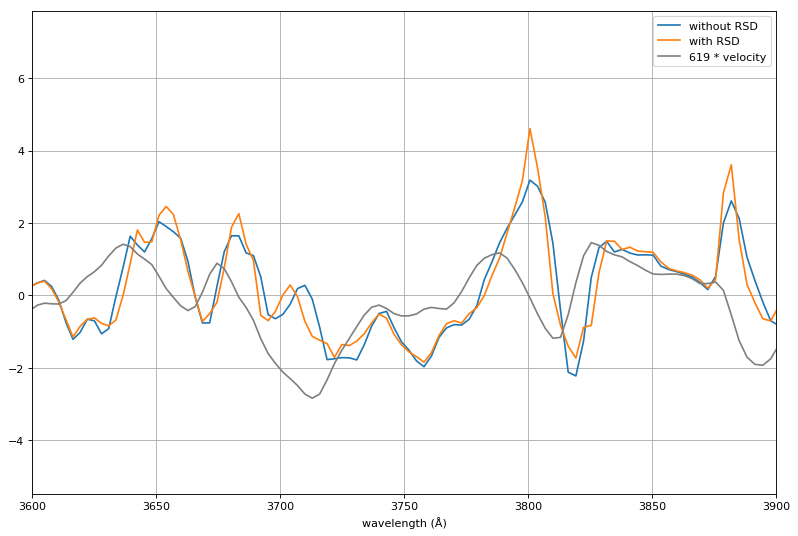

In [51]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
scale_vel = 3/max(velocity_skewer)
plt.plot(lya*(1+Z),gaussian_skewer,label='without RSD')
plt.plot(lya*(1+Z),new_gaussian_skewer,label='with RSD')
plt.plot(lya*(1+Z),scale_vel*velocity_skewer,label='{:2.0f} * velocity'.format(scale_vel),c=(0.5,0.5,0.5))

plt.xlim(x_lower,x_upper)
plt.xlabel('wavelength (Å)')
plt.legend()
plt.grid()
plt.show()